In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler

BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 43  # Number of classes for traffic signs

train_dir = "I:\DATASET\TRAFFIC SIGNS PICKLE DATA 0 224x224/train"
valid_dir = "I:\DATASET\TRAFFIC SIGNS PICKLE DATA 0 224x224/valid"
test_dir = "I:\DATASET\TRAFFIC SIGNS PICKLE DATA 0 224x224/test"

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
base_model = tf.keras.applications.MobileNetV3Large(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)  # Updated input shape
)
#custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)  # Add BatchNormalization
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Found 86989 images belonging to 43 classes.
Found 4410 images belonging to 43 classes.
Found 12630 images belonging to 43 classes.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64  

In [2]:
#learning rate scheduler
def lr_scheduler(epoch):
    if epoch < 5:
        return 0.001
    elif epoch < 10:
        return 0.0005
    else:
        return 0.0001

scheduler = LearningRateScheduler(lr_scheduler)

# Train all layers
model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    callbacks=[scheduler]
)

# freeze BatchNormalization
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train fine-tuned model
history = model.fit(
    train_generator,
    epochs=10,  # Fine-tune for 10 more epochs
    validation_data=valid_generator,
    callbacks=[scheduler]
)

Epoch 1/10
1360/1360 [==============================] - 4664s 3s/step - loss: 0.0900 - accuracy: 0.9758 - val_loss: 5.3856 - val_accuracy: 0.0556 - lr: 0.0010
Epoch 2/10
1360/1360 [==============================] - 4682s 3s/step - loss: 0.0225 - accuracy: 0.9938 - val_loss: 19.1124 - val_accuracy: 0.0497 - lr: 0.0010
Epoch 3/10
1360/1360 [==============================] - 5154s 4s/step - loss: 0.0123 - accuracy: 0.9968 - val_loss: 7.9134 - val_accuracy: 0.1340 - lr: 0.0010
Epoch 4/10
1360/1360 [==============================] - 5094s 4s/step - loss: 0.0191 - accuracy: 0.9952 - val_loss: 7.5337 - val_accuracy: 0.0172 - lr: 0.0010
Epoch 5/10
1360/1360 [==============================] - 4974s 4s/step - loss: 0.0071 - accuracy: 0.9981 - val_loss: 5.4204 - val_accuracy: 0.1587 - lr: 0.0010
Epoch 6/10
1360/1360 [==============================] - 5047s 4s/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 6.9375 - val_accuracy: 0.0587 - lr: 5.0000e-04
Epoch 7/10
1360/1360 [===================

In [19]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

198/198 [==============================] - 178s 901ms/step - loss: 0.0784 - accuracy: 0.9853
Test Accuracy: 0.9852731823921204


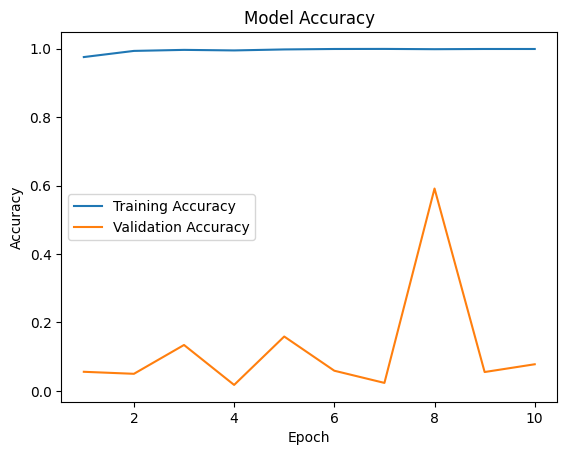

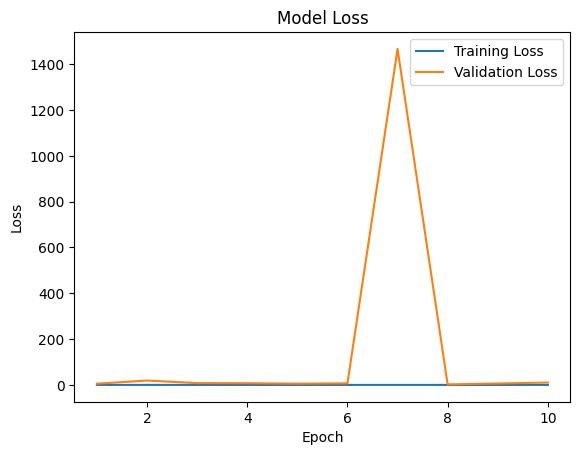

In [22]:
# Manually create lists of values from the training output
train_loss = [0.0900, 0.0225, 0.0123, 0.0191, 0.0071, 0.0021, 0.0013, 0.0046, 0.0022, 0.0021]
train_accuracy = [0.9758, 0.9938, 0.9968, 0.9952, 0.9981, 0.9994, 0.9996, 0.9988, 0.9994, 0.9994]

val_loss = [5.3856, 19.1124, 7.9134, 7.5337, 5.4204, 6.9375, 1466.7863, 2.1570, 6.1962, 10.4339]
val_accuracy = [0.0556, 0.0497, 0.1340, 0.0172, 0.1587, 0.0587, 0.0231, 0.5914, 0.0549, 0.0776]

epochs = range(1, 11)  # 10 epochs

# Now you can plot the training and validation metrics
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

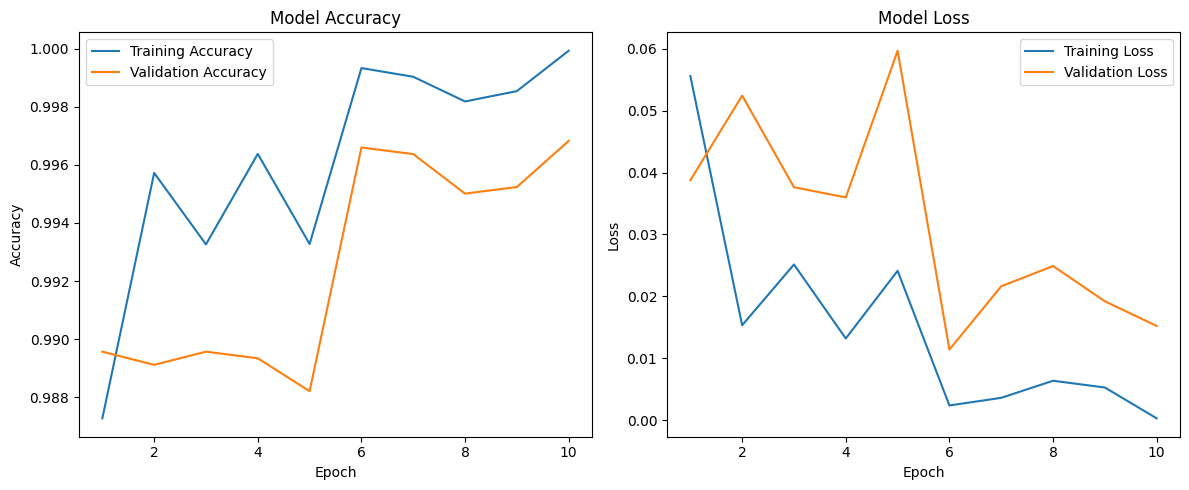

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, 11), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 11), history.history['loss'], label='Training Loss')
plt.plot(range(1, 11), history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

print("Confusion Matrix:")
print(cm)

# Classification Report
target_names = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

198/198 [==============================] - 178s 897ms/step
Confusion Matrix:
[[ 60   0   0 ...   0   0   0]
 [  0 716   0 ...   0   0   0]
 [  0   0 660 ...   0   0   0]
 ...
 [  0   0   0 ... 450   0   0]
 [  2   0   0 ...   0 447   0]
 [  0   0   0 ...   0   0 480]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        60
           1       0.98      0.99      0.99       720
          10       1.00      1.00      1.00       660
          11       1.00      0.98      0.99       420
          12       1.00      0.99      1.00       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       1.00      0.99      0.99       210
          16       0.99      1.00      1.00       150
          17       1.00      1.00      1.00       360
          18       1.00      0.97      0.99       390
          19       0.98      1.00      0.99        60
    

C:\Users\A.HAQUE\AppData\Local\Temp\ipykernel_12960\3254908555.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator)


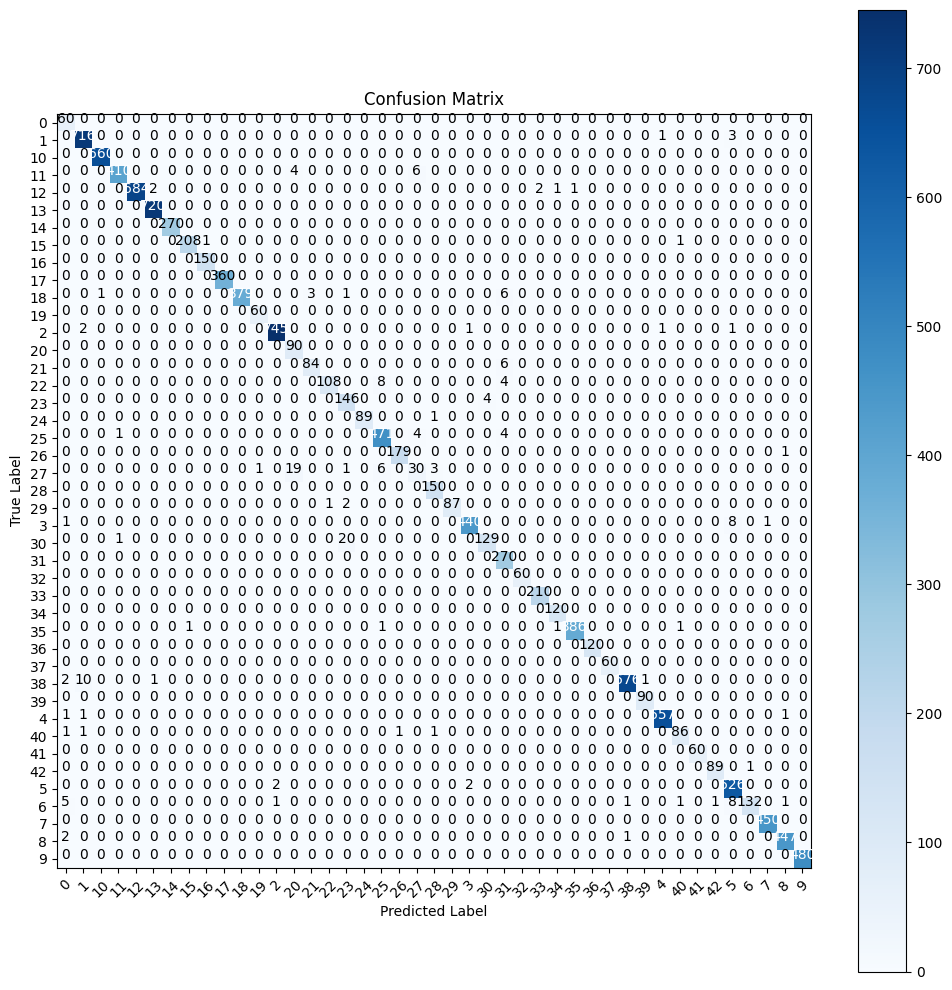

In [21]:
import itertools
from sklearn.metrics import confusion_matrix

# Get the predictions for the test data
preds = model.predict_generator(test_generator)
y_pred = np.argmax(preds, axis=1)

# Get class indices
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                                    

In [18]:
# Save the model
model.save("mobilenetv3_Large_traffic_signs.h5")
print("Model saved successfully.")

C:\Users\A.HAQUE\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully.


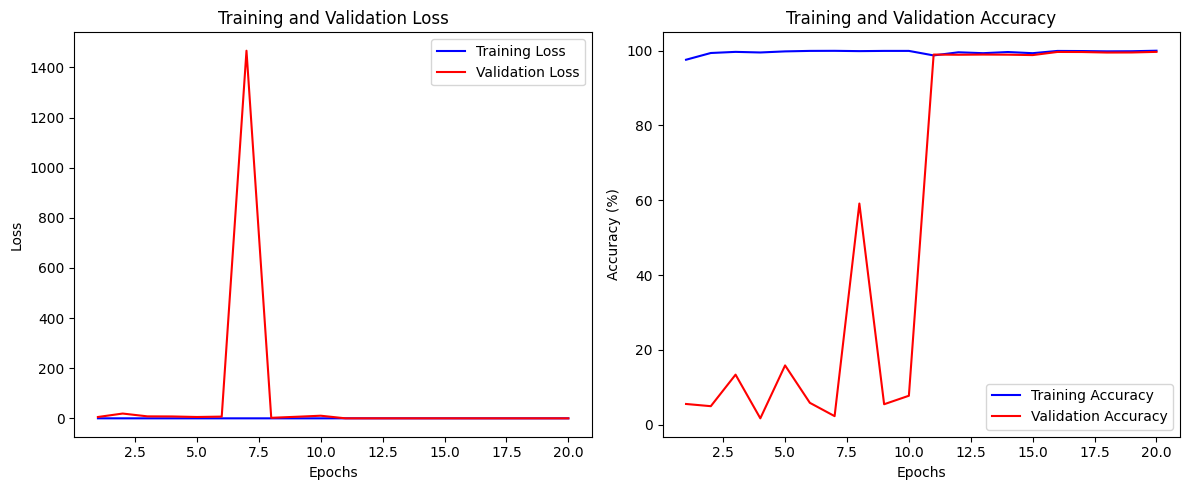

In [3]:
# COMBINED GRAPH 

import matplotlib.pyplot as plt

# Data for first set of epochs
epochs_1 = range(1, 11)
training_loss_1 = [0.0900, 0.0225, 0.0123, 0.0191, 0.0071, 0.0021, 0.0013, 0.0046, 0.0022, 0.0021]
training_accuracy_1 = [97.58, 99.38, 99.68, 99.52, 99.81, 99.94, 99.96, 99.88, 99.94, 99.94]
validation_loss_1 = [5.3856, 19.1124, 7.9134, 7.5337, 5.4204, 6.9375, 1466.7863, 2.1570, 6.1962, 10.4339]
validation_accuracy_1 = [5.56, 4.97, 13.40, 1.72, 15.87, 5.87, 2.31, 59.14, 5.49, 7.76]

# Data for second set of epochs
epochs_2 = range(11, 21)  # Adjusted x-axis values
training_loss_2 = [0.0556, 0.0153, 0.0252, 0.0132, 0.0241, 0.0024, 0.0036, 0.0064, 0.0053, 0.0003]
training_accuracy_2 = [98.73, 99.57, 99.33, 99.64, 99.33, 99.93, 99.90, 99.82, 99.85, 99.99]
validation_loss_2 = [0.0388, 0.0524, 0.0376, 0.0360, 0.0597, 0.0114, 0.0216, 0.0249, 0.0192, 0.0152]
validation_accuracy_2 = [98.96, 98.91, 98.96, 98.93, 98.82, 99.66, 99.64, 99.50, 99.52, 99.68]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(list(epochs_1) + list(epochs_2), training_loss_1 + training_loss_2, 'b', label='Training Loss')
plt.plot(list(epochs_1) + list(epochs_2), validation_loss_1 + validation_loss_2, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(list(epochs_1) + list(epochs_2), training_accuracy_1 + training_accuracy_2, 'b', label='Training Accuracy')
plt.plot(list(epochs_1) + list(epochs_2), validation_accuracy_1 + validation_accuracy_2, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()